# Does Blue/Red Side Bias Exist? — League of Legends (Diamond, 10‑min Snapshot)

**Objective:** Test whether the **blue side** has a statistically significant win‑rate advantage over the **red side** using the 10‑minute snapshot dataset.

**What you'll do in this notebook:**
1. Load and validate the dataset
2. Compute **overall blue win rate** (+ 95% CI) and run a **binomial test**
3. Visualize win counts and win rate
4. Explore **early‑game side differences** (auto‑discover `blue*` ↔ `red*` pairs and compute diffs)
5. Optional: Fit a simple **logistic regression** using early‑game differences to check directional effects
6. Summarize key findings

> **Dataset expected file name:** `high_diamond_ranked_10min.csv`  
> Place it in the same folder as this notebook or update the `DATA_PATH` below.

In [10]:


import math
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt




In [11]:

DATA_PATH = "high_diamond_ranked_10min.csv"


df = pd.read_csv(DATA_PATH)



In [12]:
# assert "blueWins" in df.columns, "Expected target column 'blueWins' not found."
unique_target = sorted(pd.Series(df["blueWins"].unique()).tolist())
print("Unique values in blueWins:", unique_target)
if not set(unique_target).issubset({0,1}):
    raise ValueError("blueWins must be binary 0/1.")


missing = df.isna().mean().sort_values(ascending=False)
print("Columns with any missingness:")
display(missing[missing>0])

Unique values in blueWins: [0, 1]
Columns with any missingness:


Series([], dtype: float64)

In [13]:
# === 3. Overall blue win rate + binomial test + 95% CI ===
blue_wins = int(df["blueWins"].sum())
n_games = int(df.shape[0])
blue_win_rate = blue_wins / n_games

# Binomial test H0: p = 0.5 (no side bias)
# Two-sided test
p_value = stats.binomtest(blue_wins, n_games, p=0.5, alternative="two-sided").pvalue

# 95% Wilson score interval for a proportion
def wilson_ci(k, n, conf=0.95):
    if n == 0:
        return (np.nan, np.nan)
    z = stats.norm.ppf(1-(1-conf)/2)
    phat = k/n
    denom = 1 + z**2/n
    center = (phat + z**2/(2*n)) / denom
    half = z * math.sqrt((phat*(1-phat) + z**2/(4*n))/n) / denom
    return (center - half, center + half)

ci_low, ci_high = wilson_ci(blue_wins, n_games, conf=0.95)

print(f"Games: {n_games:,}")
print(f"Blue wins: {blue_wins:,}")
print(f"Blue win rate: {blue_win_rate:.4f} ({blue_win_rate*100:.2f}%)")
print(f"95% CI (Wilson): [{ci_low:.4f}, {ci_high:.4f}]")
print(f"Binomial test p-value (H0: p=0.5): {p_value:.6f}")

Games: 9,879
Blue wins: 4,930
Blue win rate: 0.4990 (49.90%)
95% CI (Wilson): [0.4892, 0.5089]
Binomial test p-value (H0: p=0.5): 0.856291


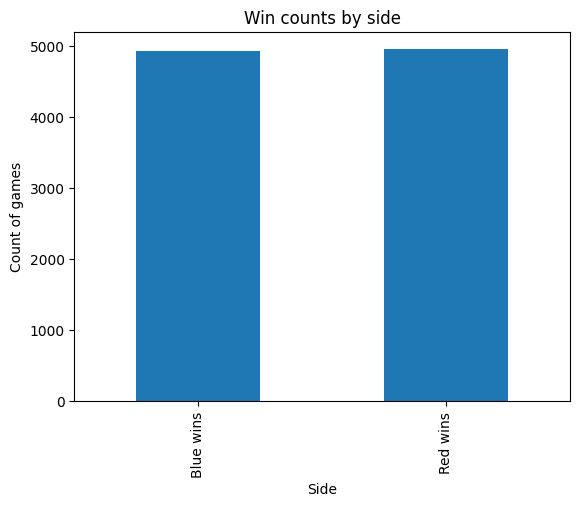

In [14]:
# === 4. Visualize win counts (bar chart) ===
counts = pd.Series({"Blue wins": blue_wins, "Red wins": n_games-blue_wins})
plt.figure()
counts.plot(kind="bar")
plt.title("Win counts by side")
plt.ylabel("Count of games")
plt.xlabel("Side")
plt.show()

In [15]:
# === 5. Auto-discover blue/red paired features and compute differences ===
# We will look for columns starting with 'blue' and check if a matching 'red' column exists
# with the same suffix (e.g., blueGold vs redGold).
blue_cols = [c for c in df.columns if c.startswith("blue")]
red_cols = [c for c in df.columns if c.startswith("red")]

def partner_name(c):
    # c is like 'blueSomething' -> returns 'redSomething'
    return "red" + c[len("blue"):]
paired = [(b, partner_name(b)) for b in blue_cols if partner_name(b) in red_cols]

print(f"Found {len(paired)} blue/red paired columns.")
paired[:10]

Found 19 blue/red paired columns.


[('blueWardsPlaced', 'redWardsPlaced'),
 ('blueWardsDestroyed', 'redWardsDestroyed'),
 ('blueFirstBlood', 'redFirstBlood'),
 ('blueKills', 'redKills'),
 ('blueDeaths', 'redDeaths'),
 ('blueAssists', 'redAssists'),
 ('blueEliteMonsters', 'redEliteMonsters'),
 ('blueDragons', 'redDragons'),
 ('blueHeralds', 'redHeralds'),
 ('blueTowersDestroyed', 'redTowersDestroyed')]

In [16]:
# Compute diffs: diff = blue - red
diff_df = pd.DataFrame(index=df.index)
for b, r in paired:
    # Only compute diffs for numeric columns
    if np.issubdtype(df[b].dtype, np.number) and np.issubdtype(df[r].dtype, np.number):
        diff_df[b.replace("blue", "diff", 1)] = df[b] - df[r]

print("Diff features created:", diff_df.shape[1])
display(diff_df.head(3))

Diff features created: 19


,diffWardsPlaced,diffWardsDestroyed,diffFirstBlood,diffKills,diffDeaths,diffAssists,diffEliteMonsters,diffDragons,diffHeralds,diffTowersDestroyed,diffTotalGold,diffAvgLevel,diffTotalExperience,diffTotalMinionsKilled,diffTotalJungleMinionsKilled,diffGoldDiff,diffExperienceDiff,diffCSPerMin,diffGoldPerMin
0,13,-4,1,3,-3,3,0,0,0,0,643,-0.2,-8,-2,-19,1286,-16,-0.2,64.3
1,0,0,-1,0,0,3,-2,-1,-1,-1,-2908,-0.2,-1173,-66,-9,-5816,-2346,-6.6,-290.8
2,0,-3,-1,-4,4,-10,1,1,0,0,-1172,-0.4,-1033,-17,18,-2344,-2066,-1.7,-117.2


In [17]:
# === 6. Summarize side differences (overall, not conditioned on winner) ===
# Show the top 15 diffs by absolute mean magnitude
diff_summary = pd.DataFrame({
    "mean": diff_df.mean(),
    "std": diff_df.std(),
    "median": diff_df.median()
}).sort_values("mean", key=lambda s: s.abs(), ascending=False)

display(diff_summary.head(15))

,mean,std,median
diffExperienceDiff,-67.240611,3840.740876,-56.0
diffTotalExperience,-33.620306,1920.370438,-28.0
diffGoldDiff,28.828221,4906.698359,28.0
diffTotalGold,14.414111,2453.349179,14.0
diffGoldPerMin,1.441411,245.334918,1.4
diffTotalJungleMinionsKilled,-0.803421,14.274733,0.0
diffTotalMinionsKilled,-0.649661,30.942675,-1.0
diffWardsDestroyed,0.101731,2.854910,0.0
diffWardsPlaced,-0.079664,25.960582,0.0
diffCSPerMin,-0.064966,3.094267,-0.1


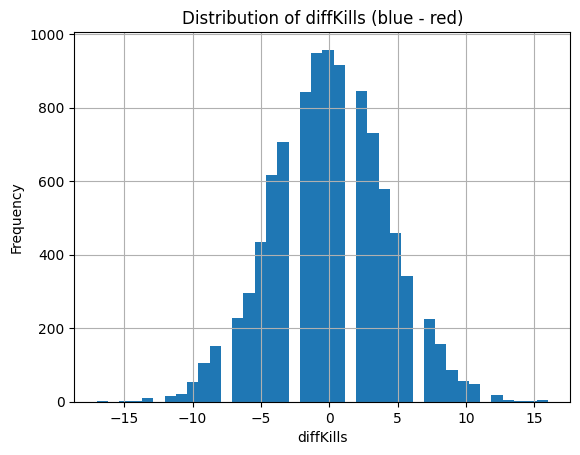

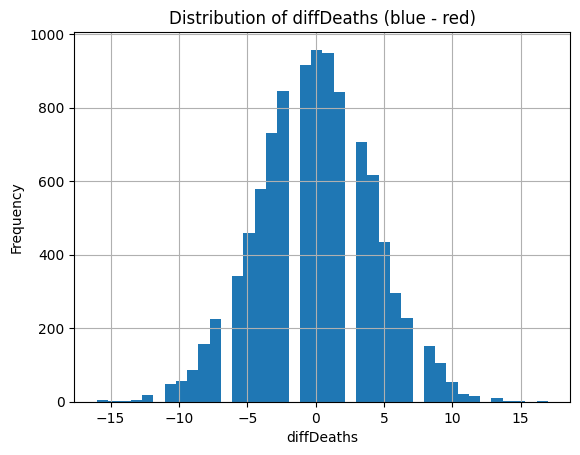

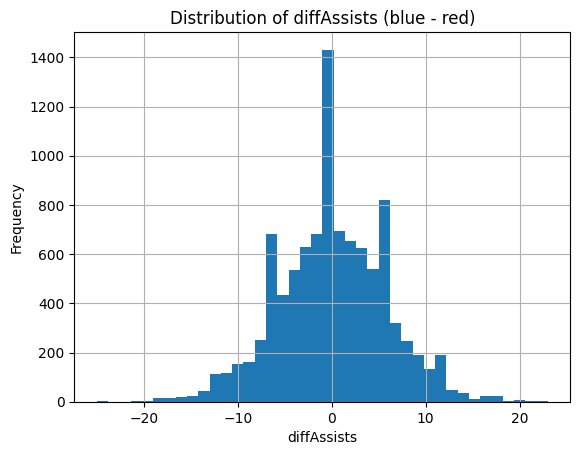

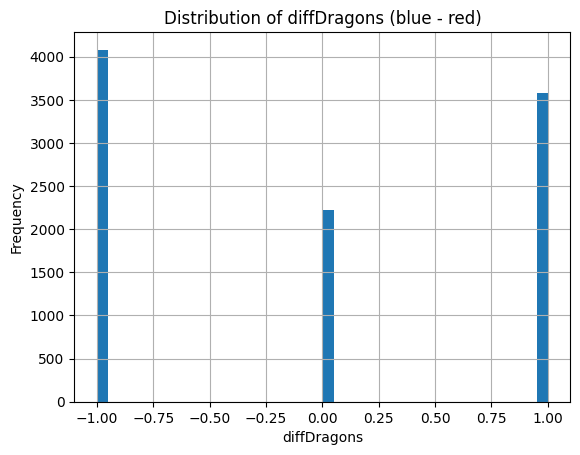

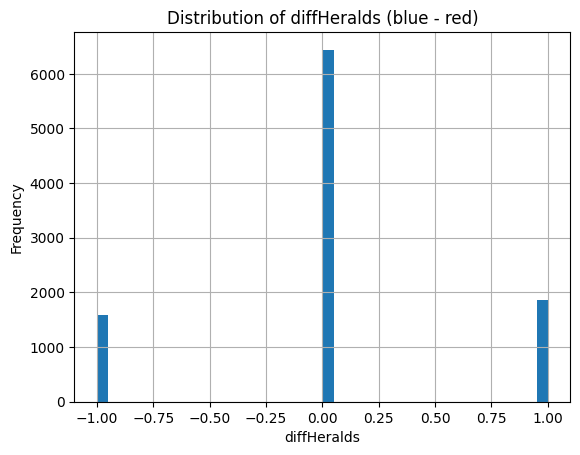

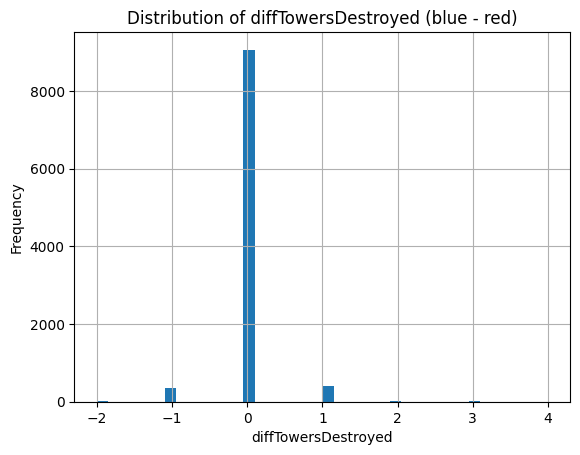

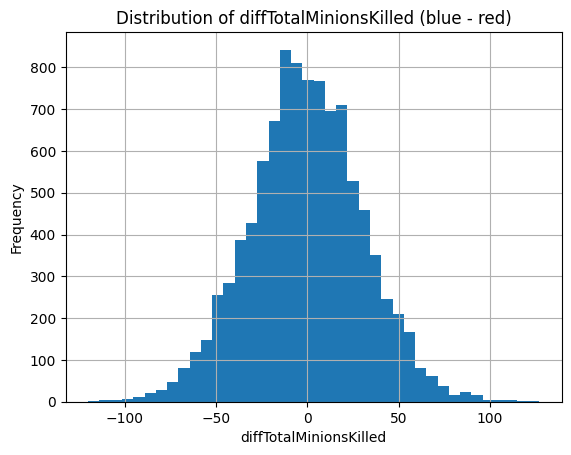

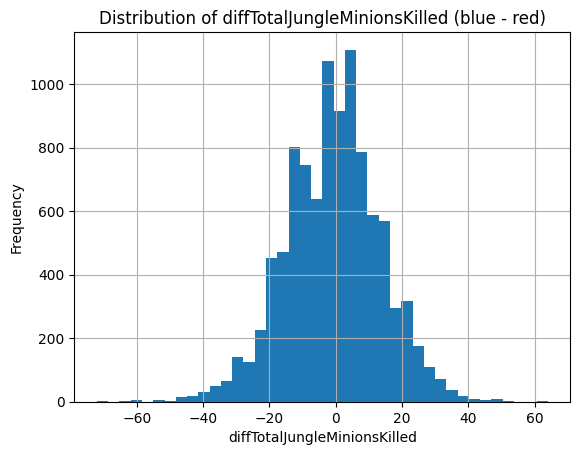

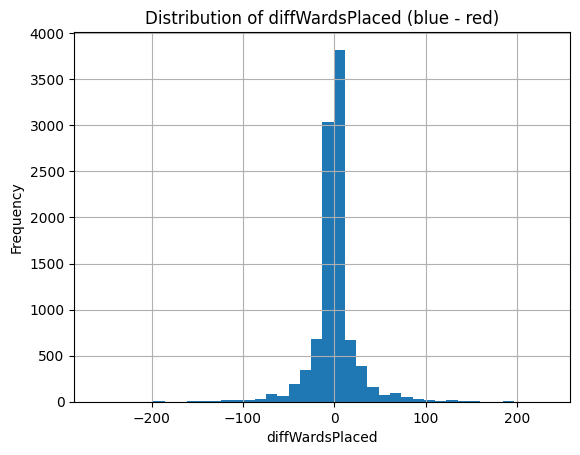

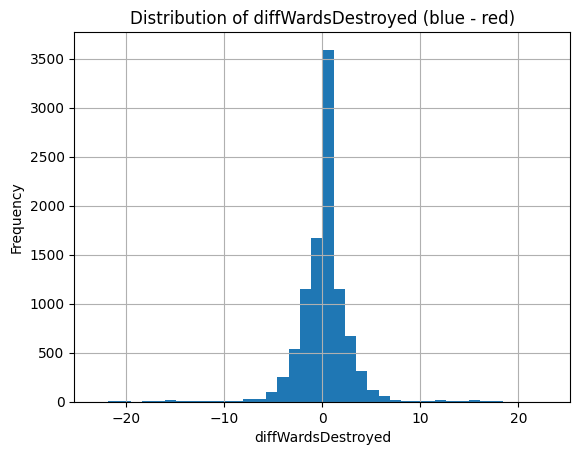

In [18]:
# === 7. Visualize a few key diffs, if present ===
# We try common ones safely by name matching
candidate_suffixes = [
    "Gold", "Experience", "Kills", "Deaths", "Assists",
    "Dragons", "Heralds", "TowersDestroyed", "TotalMinionsKilled",
    "TotalJungleMinionsKilled", "WardsPlaced", "WardsDestroyed"
]

# Map expected 'blueX' to 'diffX'
for suf in candidate_suffixes:
    diff_col = f"diff{suf}"
    if diff_col in diff_df.columns:
        plt.figure()
        diff_df[diff_col].hist(bins=40)
        plt.title(f"Distribution of {diff_col} (blue - red)")
        plt.xlabel(diff_col)
        plt.ylabel("Frequency")
        plt.show()

In [19]:
# === 8. Conditioned analysis: diffs stratified by outcome ===
# This helps see which early advantages are linked with winning.
if "blueWins" in df.columns:
    joined = pd.concat([df["blueWins"], diff_df], axis=1)
    # Compute group means
    grp_means = joined.groupby("blueWins").mean().T
    display(grp_means.head(15))

    # Simple bar for a key available diff (e.g., diffGold or diffExperience), if present
    for key in ["diffGold", "diffExperience"]:
        if key in diff_df.columns:
            plt.figure()
            grp_means.loc[key].plot(kind="bar")
            plt.title(f"{key} by outcome (0=Red win, 1=Blue win)")
            plt.ylabel("Mean difference")
            plt.xlabel("Outcome")
            plt.show()

blueWins,0,1
diffWardsPlaced,-0.517276,0.359635
diffWardsDestroyed,-0.112548,0.316836
diffFirstBlood,-0.191756,0.211765
diffKills,-1.961002,2.061258
diffDeaths,1.961002,-2.061258
diffAssists,-2.237826,2.212373
diffEliteMonsters,-0.300263,0.254970
diffDragons,-0.256617,0.155172
diffHeralds,-0.043645,0.099797
diffTowersDestroyed,-0.042231,0.059229


Top features: ['diffGoldDiff', 'diffTotalGold', 'diffGoldPerMin', 'diffExperienceDiff', 'diffTotalExperience', 'diffKills', 'diffDeaths', 'diffAvgLevel', 'diffAssists', 'diffTotalMinionsKilled']
Accuracy: 0.719 AUC: 0.805
              precision    recall  f1-score   support

           0      0.716     0.727     0.722      1237
           1      0.722     0.711     0.717      1233

    accuracy                          0.719      2470
   macro avg      0.719     0.719     0.719      2470
weighted avg      0.719     0.719     0.719      2470



,feature,coef
2,diffGoldPerMin,0.380164
0,diffGoldDiff,0.380164
1,diffTotalGold,0.380164
3,diffExperienceDiff,0.218706
4,diffTotalExperience,0.218706
9,diffTotalMinionsKilled,-0.123099
8,diffAssists,-0.051117
7,diffAvgLevel,0.022819
5,diffKills,0.008803
6,diffDeaths,-0.008803


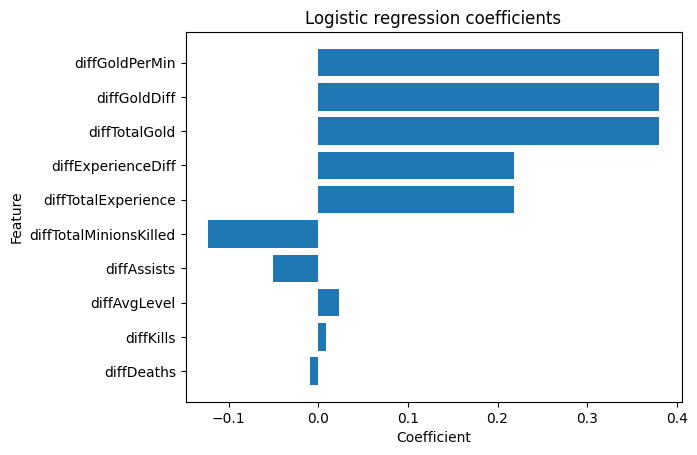

In [20]:
# === 9. Optional: simple logistic regression with a few diffs ===
# This is to check directional effects; it does NOT "prove" bias,
# but shows whether early differences predict a blue-side win.
try:
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

    # Pick up to 10 most-informative diffs by absolute correlation with blueWins
    corr = pd.concat([df["blueWins"], diff_df], axis=1).corr()["blueWins"].drop("blueWins", errors="ignore")
    top_features = corr.abs().sort_values(ascending=False).head(10).index.tolist()

    X = diff_df[top_features].fillna(0.0)
    y = df["blueWins"].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)

    clf = LogisticRegression(max_iter=200)
    clf.fit(X_train_sc, y_train)
    y_prob = clf.predict_proba(X_test_sc)[:,1]
    y_pred = (y_prob >= 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print("Top features:", top_features)
    print("Accuracy:", f"{acc:.3f}", "AUC:", f"{auc:.3f}")
    print(classification_report(y_test, y_pred, digits=3))

    # Coefficients (bigger magnitude => stronger effect)
    coef_df = pd.DataFrame({
        "feature": top_features,
        "coef": clf.coef_[0]
    }).sort_values("coef", key=lambda s: s.abs(), ascending=False)

    display(coef_df)

    # Plot coefficients
    plt.figure()
    plt.barh(coef_df["feature"], coef_df["coef"])
    plt.title("Logistic regression coefficients")
    plt.xlabel("Coefficient")
    plt.ylabel("Feature")
    plt.gca().invert_yaxis()
    plt.show()

except Exception as e:
    print("Optional modeling skipped:", e)

In [21]:
# === 10. Conclusion helper ===
print("SUMMARY")
print("- If the binomial test p-value < 0.05 and the 95% CI for the blue win rate excludes 0.50,")
print("  then the blue side exhibits a statistically significant win-rate advantage.")
print("- Diff summaries and stratified means show which early-game differences (blue - red)")
print("  accompany that advantage (e.g., gold, XP, objectives, vision).")
print("- The optional logistic regression checks whether these early differences predict blue wins,")
print("  but remember correlation is not causation; patch/meta and matchmaking effects are not modeled here.")

SUMMARY
- If the binomial test p-value < 0.05 and the 95% CI for the blue win rate excludes 0.50,
  then the blue side exhibits a statistically significant win-rate advantage.
- Diff summaries and stratified means show which early-game differences (blue - red)
  accompany that advantage (e.g., gold, XP, objectives, vision).
- The optional logistic regression checks whether these early differences predict blue wins,
  but remember correlation is not causation; patch/meta and matchmaking effects are not modeled here.
